In [1]:
# Vaguely following this lesson plan:
# http://course.fast.ai/lessons/lesson4.html

%reload_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
import os.path
assert os.path.basename(os.getcwd()) == 'notebooks', os.path.basename(os.getcwd())
code_dir = os.path.join(os.getcwd(), os.pardir, 'code')
if code_dir not in sys.path:
    sys.path.append(code_dir)
    os.environ['PYTHONPATH'] = os.environ.get('PYTHONPATH', '') + os.pathsep + code_dir
model_dir = os.path.join(os.getcwd(), os.pardir, 'models')
    
# Keras warns about non-keras optimizers
import warnings
warnings.simplefilter("ignore", UserWarning)
import keras
%aimport keras_util

Using TensorFlow backend.


In [2]:
from keras.utils import get_file

ml20_origin = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
get_file('ml-20m.zip', ml20_origin, cache_dir='../data', cache_subdir='movielens', extract=True)
ml20_path = '../data/movielens/ml-20m/'
! echo && ls {ml20_path}


README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


In [3]:
import pandas as pd
ratings = pd.read_csv(ml20_path + 'ratings.csv')

In [4]:
# Convert movies to indices
import numpy as np

unique_users = ratings.userId.unique()
unique_movies = ratings.movieId.unique()
print('unique count', len(unique_users), len(unique_movies))
print('max id', unique_users.max(), unique_movies.max())
users_unique = pd.Series(np.arange(len(unique_users)), index=unique_users)
movies_unique = pd.Series(np.arange(len(unique_movies)), index=unique_movies)

ratings.userId = ratings.userId.map(users_unique)
ratings.movieId = ratings.movieId.map(movies_unique)
print('max normalized id', ratings.userId.max(), ratings.movieId.max())

n_users = len(users_unique)
n_movies = len(movies_unique)

from IPython.display import display
ratings.drop('timestamp', axis=1, inplace=True)
display(ratings.head())

unique count 138493 26744
max id 138493 131262
max normalized id 138492 26743


,userId,movieId,rating
0,0,0,3.5
1,0,1,3.5
2,0,2,3.5
3,0,3,3.5
4,0,4,3.5


In [5]:
movie_factors = 50
user_factors = n_users * movie_factors // n_movies

In [6]:
from keras.layers import * 
from keras.regularizers import l2
from keras.models import Model

def recommender_net():
    keras_util.seedall()

    user_in = Input(shape=(1,), dtype='int64', name='user_in')
    u = Embedding(n_users, user_factors, input_length=1)(user_in)
    movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
    m = Embedding(n_movies, movie_factors, input_length=1)(movie_in)
    u = Dense(50, activation='relu')(u)
    um = Dot(axes=2)([u, m])

    # Per-user and per-movie bias (to catch "generally good movies" and "generally nice raters")
    ub = Embedding(n_users, 1, input_length=1, name='user_bias')(user_in)
    mb = Embedding(n_movies, 1, input_length=1, name='movie_bias')(movie_in)

    biased = Add()([um, ub, mb])

    return Model([user_in, movie_in], Flatten()(biased))

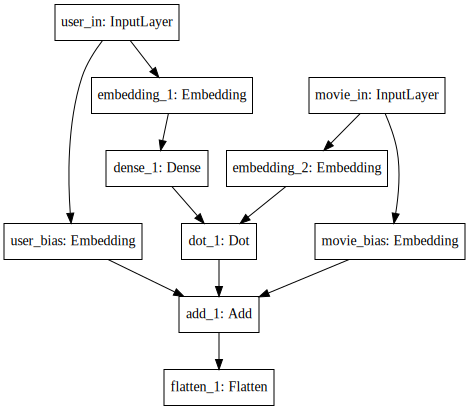

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot
import graphviz
import keras.backend as K

K.clear_session()
SVG(model_to_dot(recommender_net()).create(prog='dot', format='svg'))

In [8]:
from sklearn.model_selection import train_test_split
train_and_valid, test = train_test_split(ratings, test_size=0.3, random_state=1234)
train, valid = train_test_split(train_and_valid, test_size=0.3, random_state=5678)

In [9]:
from yellowfin import YFOptimizer
from keras import optimizers

opts = {
        'sgd+clip':
        lambda: optimizers.SGD(clipvalue=1),
        'sgd+momentum+clip':
        lambda: optimizers.SGD(momentum=0.9, nesterov=True, clipvalue=1),
        'adam+clip':
        lambda: optimizers.Adam(clipvalue=1),
        'nadam+clip':
        lambda: optimizers.Nadam(clipvalue=1),
        'adamax+clip':
        lambda: optimizers.Adamax(clipvalue=1),
# This just doesn't work right now (model-saving issue)
#        'yellowfin+clip':
#        lambda: optimizers.TFOptimizer(YFOptimizer(clip_thresh=1))
    }

In [10]:
import ray
ray.init(num_gpus=len(keras_util.get_available_gpus()))

Waiting for redis server at 127.0.0.1:42290 to respond...
Waiting for redis server at 127.0.0.1:62818 to respond...
Starting local scheduler with 32 CPUs and 2 GPUs.
View the web UI at http://localhost:8888/notebooks/ray_ui74773.ipynb


{'local_scheduler_socket_names': ['/tmp/scheduler61834996'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store42710940', manager_name='/tmp/plasma_manager83795661', manager_port=51952)],
 'redis_address': '127.0.0.1:42290'}

In [12]:
import contexttimer
import time
import tensorflow as tf
import keras

model_dir = os.path.join(os.getcwd(), os.pardir, 'models')

@ray.remote(num_gpus=1, max_calls=1)
def train_recommender(optname):
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, ray.get_gpu_ids()))
    with tf.Session() as sess:
        with sess.as_default():
            K.set_session(sess)
            with keras_util.tmp_cd(os.path.join(model_dir, optname)):
                
                if os.path.isfile('history'):
                    update('already trained')
                    return load_object('history')

                net = recommender_net()
                net.compile(loss='mse', optimizer=opts[optname]())

                tb = keras.callbacks.TensorBoard(log_dir='.')
                checkpoint = keras.callbacks.ModelCheckpoint(
                    filepath='net', monitor='val_loss', save_best_only=True)
                earlystop = keras.callbacks.EarlyStopping(
                    monitor='val_loss', min_delta=0, patience=0)

                print('{} starting training\n'.format(optname), end='')
                with contexttimer.Timer() as t:
                    hist = net.fit(
                        [train.userId, train.movieId],
                        train.rating,
                        epochs=100,
                        batch_size=500000,
                        callbacks=[checkpoint, tb, earlystop],
                        verbose=0,
                        validation_data=([valid.userId, valid.movieId], valid.rating))
                keras_util.save_object(hist.history, 'history')
                print(
                    '{} completed training in {} sec\n'.format(optnameint(t.elapsed)),
                    end='')
                return hist.history


r = train_recommender.remote('adamax+clip')
ray.get(r)

Remote function __main__.train_recommender

RayGetError: Could not get objectid ObjectID(243e507e3fce061ee9023ba2824c6fcbe6006e3c). It was created by remote function [31m__main__.train_recommender[39m which failed with:

Remote function [31m__main__.train_recommender[39m failed with:

Traceback (most recent call last):
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [138493,258] and type float
	 [[Node: Const_40 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [138493,258] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/ray/worker.py", line 1768, in process_task
    outputs = function_executor.executor(arguments)
  File "/usr/local/lib/python3.5/dist-packages/ray/worker.py", line 2009, in func_executor
    result = func(*arguments)
  File "<ipython-input-12-937d4083b900>", line 38, in train_recommender
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training.py", line 1430, in fit
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training.py", line 1040, in _fit_loop
    callbacks.set_model(callback_model)
  File "/usr/local/lib/python3.5/dist-packages/keras/callbacks.py", line 52, in set_model
    callback.set_model(model)
  File "/usr/local/lib/python3.5/dist-packages/keras/callbacks.py", line 651, in set_model
    self.sess = K.get_session()
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 168, in get_session
    _initialize_variables()
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 341, in _initialize_variables
    sess.run(tf.variables_initializer(uninitialized_variables))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 789, in run
    run_metadata_ptr)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 997, in _run
    feed_dict_string, options, run_metadata)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1132, in _do_run
    target_list, options, run_metadata)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1152, in _do_call
    raise type(e)(node_def, op, message)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [138493,258] and type float
	 [[Node: Const_40 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [138493,258] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'Const_40', defined at:
  File "/usr/local/lib/python3.5/dist-packages/ray/workers/default_worker.py", line 61, in <module>
    ray.worker.main_loop()
  File "/usr/local/lib/python3.5/dist-packages/ray/worker.py", line 1838, in main_loop
    process_task(task)
  File "/usr/local/lib/python3.5/dist-packages/ray/worker.py", line 1768, in process_task
    outputs = function_executor.executor(arguments)
  File "/usr/local/lib/python3.5/dist-packages/ray/worker.py", line 2009, in func_executor
    result = func(*arguments)
  File "<ipython-input-12-937d4083b900>", line 38, in train_recommender
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training.py", line 1413, in fit
    self._make_train_function()
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training.py", line 937, in _make_train_function
    self.total_loss)
  File "/usr/local/lib/python3.5/dist-packages/keras/optimizers.py", line 485, in get_updates
    ms = [K.zeros(shape) for shape in shapes]
  File "/usr/local/lib/python3.5/dist-packages/keras/optimizers.py", line 485, in <listcomp>
    ms = [K.zeros(shape) for shape in shapes]
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 602, in zeros
    return variable(tf.constant_initializer(0., dtype=tf_dtype)(shape),
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py", line 203, in __call__
    verify_shape=verify_shape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [138493,258] and type float
	 [[Node: Const_40 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [138493,258] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]



 failed with:

Traceback (most recent call last):
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [138493,258] and type float
	 [[Node: Const_40 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [138493,258] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/ray/worker.py", line 1768, in process_task
    outputs = function_executor.executor(arguments)
  File "/usr/local/lib/python3.5/dist-packages/ray/worker.py", line 2009, in func_executor
    result = func(*arguments)
  File "<ipython-input-12-937

In [ ]:
1+1

In [ ]:
import os
for losstype in ['loss', 'val_loss']:
    for optname in opts.keys():
        filename = os.path.join(model_dir, optname, 'history')
        hist = load_object(filename)[losstype]
        plt.semilogy(hist, label=opt)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.)
    plt.title(losstype + ' vs epoch')
    plt.show()

In [18]:
# Easy version
import tensorflow as tf
@ray.remote(num_gpus=1)
def train_recommender(optname):
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, ray.get_gpu_ids()))
    # Create a TensorFlow session. TensorFlow will restrict itself to use the
    # GPUs specified by the CUDA_VISIBLE_DEVICES environment variable.
    with tf.Session(graph=tf.Graph(), config=tf.ConfigProto(log_device_placement=True)) as sess:
        with sess.as_default():
            K.set_session(sess)
            net = recommender_net()
            net.compile(loss='mse', optimizer='adam')
            with tf.device('gpu'):
                c = tf.constant(1) + tf.constant(1)
            return sess.run(c)
K.clear_session()
ray.get(train_recommender.remote('asdf'))

2